In [1]:
import sys
sys.path.append('../../')

In [52]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import regression_efficacy_metrics

In [53]:
dataset = load_diabetes() # load dataset

X = dataset.data # features
y = dataset.target # target 
feature_names = dataset.feature_names # feature names

X = pd.DataFrame(X, columns=feature_names) # convert to dataframe

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'bp'}>, <Axes: title={'center': 's1'}>,
        <Axes: title={'center': 's2'}>],
       [<Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's5'}>],
       [<Axes: title={'center': 's6'}>, <Axes: >, <Axes: >]], dtype=object)

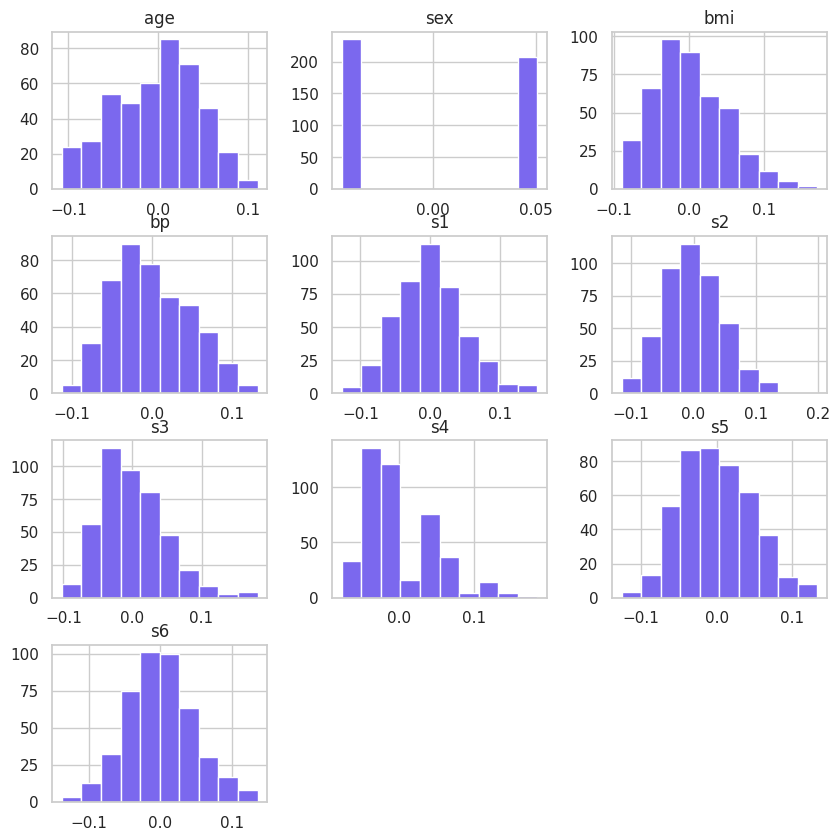

In [54]:
X.hist(bins=10, figsize=(10, 10), color = 'mediumslateblue')

<Axes: >

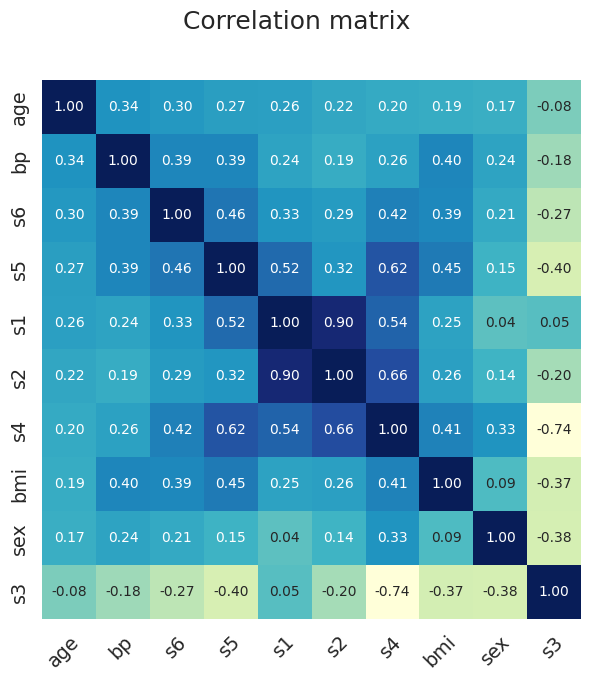

In [55]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

In [278]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split

#model = GradientBoostingRegressor() # instantiate model
model = LinearRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

In [279]:
# compute efficacy metrics
regression_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
RMSE,53.853446,0
MAE,42.794095,0
MAPE,0.374998,0
Max Error,154.493375,0
SMAPE,0.317026,0


In [280]:
# permutation feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [281]:
def importance_range_constrast(
    feature_importance_indexes: np.ndarray,
    conditional_feature_importance_indexes: np.ndarray,
):
    """
    Parameters
    ----------
    feature_importance_indexes: np.array
        array with feature importance indexes
    conditional_feature_importance_indexes: np.array
        array with conditional feature importance indexes
    """
    m_range = []
    for top_k in range(1, len(feature_importance_indexes) + 1):
        ggg = set(feature_importance_indexes[:top_k])
        vvv = set(conditional_feature_importance_indexes[:top_k])
        u = len(set(ggg).intersection(vvv)) / top_k
        m_range.append(u)
    m_range = np.array(m_range)

    return m_range.mean()

def importance_order_constrast(
    feature_importance_indexes: np.ndarray,
    conditional_features_importance_indexes: np.ndarray,
):
    """
    Parameters
    ----------
    feature_importance_indexes: np.array
        array with feature importance indexes
    conditional_feature_importance_indexes: np.array
        array with conditional feature importance indexes
    """
    m_order = np.array(feature_importance_indexes) == np.array(
        conditional_features_importance_indexes
    )
    m_order = np.cumsum(m_order) / np.arange(1, len(m_order) + 1)

    return m_order.mean()

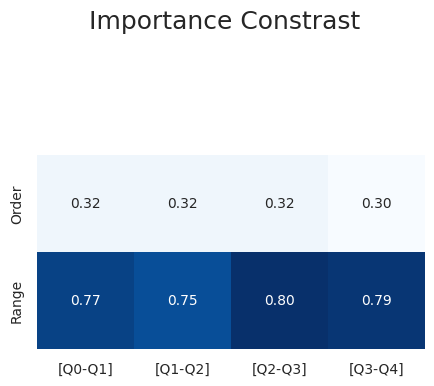

In [282]:
# Base Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def compare_importances(cfimp, fimp, keys, compare_fn):
    total_values = 2*len(keys)-1
    values = np.zeros(shape=(1,total_values))
    xticks = ['|']*total_values
    for i in range(1,len(keys)):
        values[0,2*i-1] = compare_fn(cfimp[keys[i-1]]['Variable'], cfimp[keys[i]]['Variable'])
        
    for i in range(len(keys)):
        values[0,2*i] = compare_fn(fimp['Variable'], cfimp[keys[i]]['Variable'])
        xticks[2*i] = keys[i]
    return xticks , values

def compare_importances_only_nodes(cfimp, fimp, keys, compare_fn):
    total_values = len(keys)
    values = np.zeros(shape=(1,total_values))
    xticks = ['|']*total_values
    for i in range(len(keys)):
        values[0,i] = compare_fn(fimp['Variable'], cfimp[keys[i]]['Variable'])
        xticks[i] = keys[i]
    return xticks , values

importances = explainer.explainer_handler.get_topk(top_k=None)
cfimp = importances['conditional_feature_importance']
fimp = importances['feature_importance']
keys = list(cfimp.keys())

xticks , range_values = compare_importances_only_nodes(cfimp, fimp, keys, importance_range_constrast)
xticks , order_values = compare_importances_only_nodes(cfimp, fimp, keys, importance_order_constrast)
values = np.concatenate([order_values, range_values], axis=0)
        
sns.set(font_scale=1.25)
size=5,5
fig, ax = plt.subplots(figsize=size)
fig.suptitle("Importance Constrast")
cmap="Blues"

ax = sns.heatmap(
    values,
    cbar=False,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=['Order','Range'],
    xticklabels=xticks,
    cmap=cmap,
)
_ = plt.setp(ax.get_xticklabels(), fontsize=10, ha="center")
_ = plt.setp(ax.get_yticklabels(), fontsize=10)

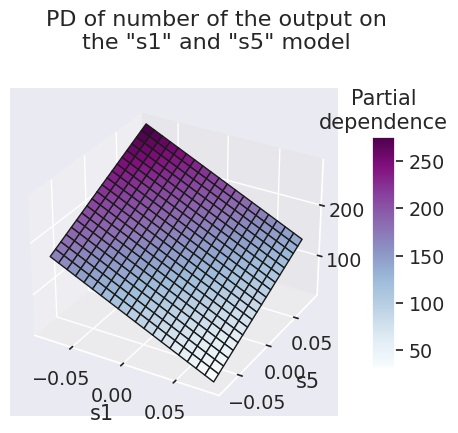

In [283]:
import numpy as np
from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(5.5,5))

features=tuple(fimp['Variable'].iloc[:2].tolist())
pdp = partial_dependence(model, X_train, features=features, kind='average', grid_resolution=20)

XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    f"PD of number of the output on\nthe \"{features[0]}\" and \"{features[1]}\" model",
    fontsize=16,
)
# pretty init view
#ax.view_init(elev=0, azim=180)
clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show()

In [198]:
explainer.metrics()

,Value,Reference
Fourth Fifths,0.400000,0
Importance Spread Divergence,0.460785,-
Importance Spread Ratio,0.799884,0
Global Overlap Score [Q0-Q1],0.010000,1
Global Overlap Score [Q1-Q2],0.485794,1
Global Overlap Score [Q2-Q3],0.047897,1
Global Overlap Score [Q3-Q4],0.746865,1
Global Range Overlap Score [Q0-Q1],0.618929,1
Global Range Overlap Score [Q1-Q2],0.799484,1
Global Range Overlap Score [Q2-Q3],0.607817,1


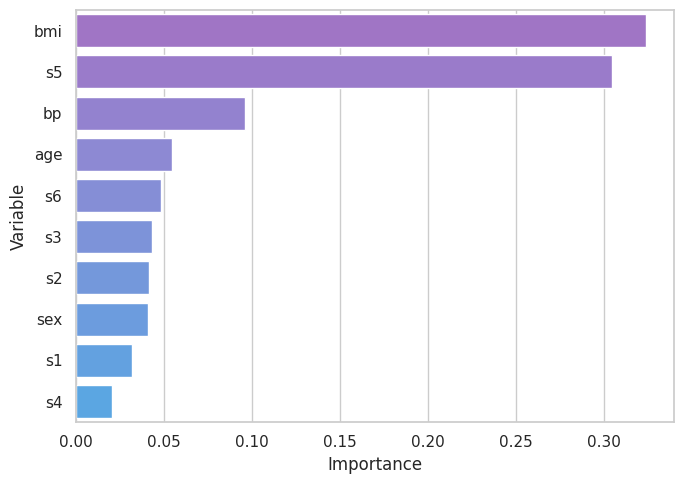

In [200]:
explainer.bar_plot(max_display=10)

In [12]:
# surrogate feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [13]:
explainer.metrics()

,Value,Reference
Fourth Fifths,0.100000,0
Importance Spread Divergence,1.510041,-
Importance Spread Ratio,0.344197,0
Global Explainability Score,1.000000,1
Surrogate Efficacy Regression,0.331254,0


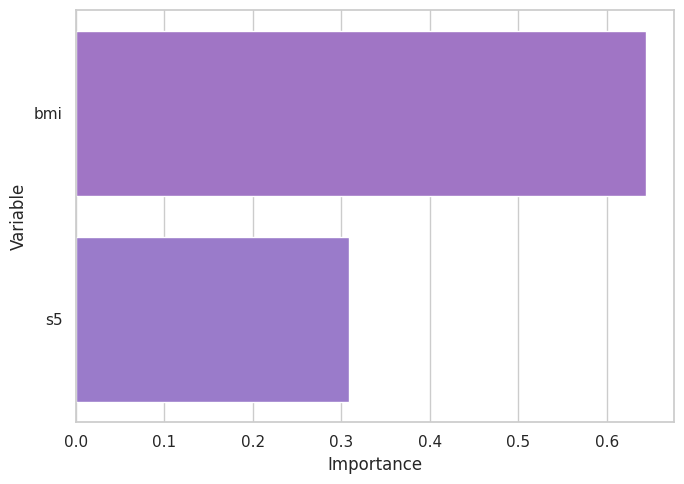

In [14]:
explainer.bar_plot(max_display=2)

In [15]:
img_tree = explainer.visualization('Decision Tree dtreeviz')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

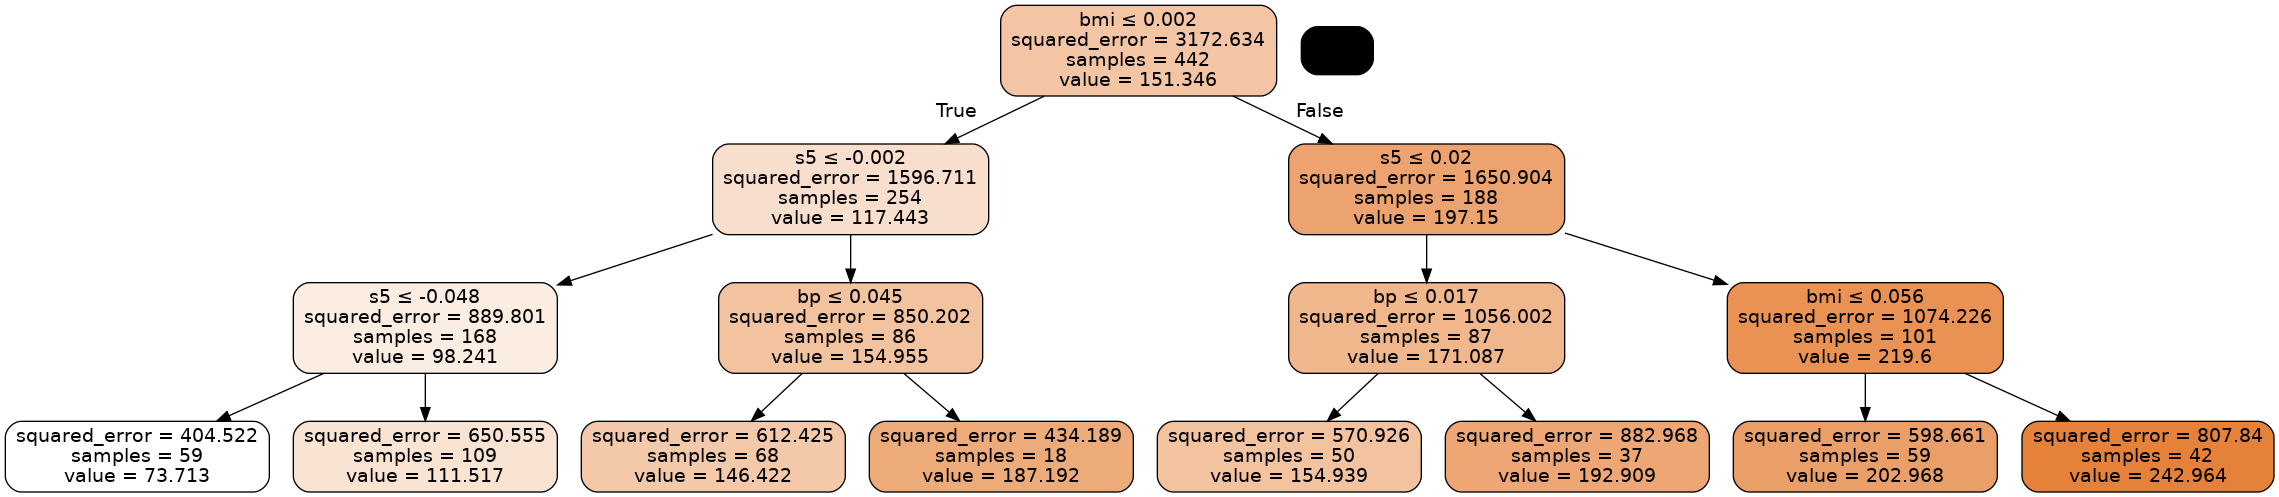

In [18]:
explainer.visualization('Decision Tree graphviz')

In [19]:
# lime feature importance
explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='regression',
                      model = model, 
                      x = X, 
                      y = y)

In [20]:
explainer.metrics()

,Value,Reference
Dataset Spread Stability,0.077928,0
Dataset Spread Mean,0.332019,0
Dataset Spread Ratio,0.979760,0
Features Spread Stability,0.149039,0
Features Spread Mean,0.143974,0
Features Spread Ratio,0.935273,0


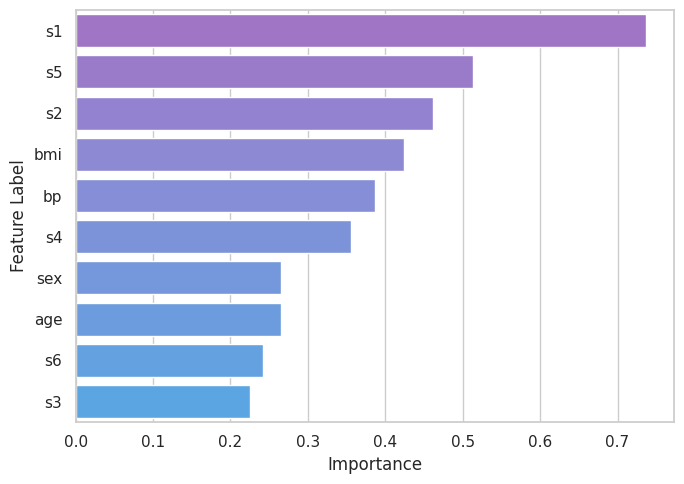

In [21]:
explainer.bar_plot(max_display=10)